In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams['animation.html'] = 'html5'

from elastic_body import *
from spectral import *
from utils import *
from simulation import *

import sys
import os
import pathlib

## Load simulation results

In [2]:
prefix = '2022Mar23_15-05-58_test_retarded_'
path_prefix = os.path.join(PROJ_DIR, RESULTS_DIR, prefix)
f = open(path_prefix + PARAMS_FILENAME, 'r')
params_dict = parse_input_file(f)
f.close()

body, mesh = create_body_and_mesh(params_dict)
t0, dt, tmax = params_dict[START_TIME], params_dict[TIME_STEP], params_dict[STOP_TIME]
T = np.arange(t0, tmax + dt, dt)
U_func = np.load(path_prefix + U_FILENAME + '.npy')
U = TensorField(mesh, U_func)

## Longitudinal strain in bar cross-section at different time moments

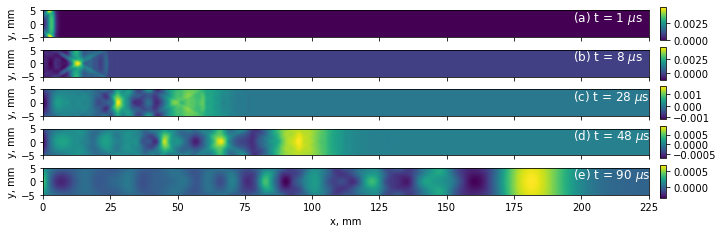

In [3]:
t = [5, 12, 32, 52, -1]
xmax = U.mesh.grid()[0][-1]
x = np.linspace(-0, xmax, num=501)
fig, ax = plot_deformations_many_scales(U, T, t, x=x)

## Video animation

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(14,6))

x = np.linspace(U.mesh.grid()[0][0], U.mesh.grid()[0][-1], 1001)
y = np.linspace(U.mesh.grid()[1][0], U.mesh.grid()[1][-1], 201)
u = -U[0, 0](None, None, 0).diff(0).real
v =  U[0, 1](None, None, 0).real

im_u = ax[0].imshow(u(x, y).T, extent=(x.min(), x.max(), y.min(), y.max()), aspect='equal')
cbar_ax_u = fig.add_axes([0.9, 0.7, 0.015, 0.19])
#cbar_ax_u.set_ylabel('u')
cbar_ax_u.set_title('$-\\partial u/\\partial x$', pad=10)
cb_u = fig.colorbar(im_u, cax=cbar_ax_u)
ax[0].set_aspect('auto')
ax[0].set_ylabel('y, mm')

im_v = ax[1].imshow(np.flipud(v(x, y).T), extent=(x.min(), x.max(), y.min(), y.max()), vmin=-0.01, vmax=0.01, aspect='equal')
cbar_ax_v = fig.add_axes([0.9, 0.45, 0.015, 0.19])
cbar_ax_v.set_title('$v$')
cb_v = fig.colorbar(im_v, cax=cbar_ax_v)
ax[1].set_aspect('auto')
ax[1].set_ylabel('y, mm')

line_u, = ax[-1].plot(x, u.int(1)(x)/(y.max() - y.min()), label='$-\\int\\frac{\\partial u}{\\partial x} dy$')
line_v, = ax[-1].plot(x, v(x, y.max()), label='$v(x, H/2)$')
ax[-1].legend(loc='upper right')
ax[-1].set_xlim(x[0], x[-1])
ax[-1].set_ylim(-0.002, 0.002)
ax[-1].grid()
ax[-1].set_xlabel('x, mm')
#ax[0].set_title(r'Time = %.1f $\mu$s, $\sigma_0 = %g$, $a_0=%g$' % (t, sigma0, a0))
time_template = 'time = %.1f us'
time_text = ax[1].text(0.82, 0.85, '', transform=ax[1].transAxes)

plt.subplots_adjust(left=0.13, right=0.88, top=0.89, bottom=0.2, hspace=0.4)
plt.close()

def animate(k):
    du_dx = -U[k, 0](None, None, 0).diff(0).real
    v =  U[k, 1](None, None, 0).real
    du_dx_2d = du_dx(x, y)
    v_2d = v(x, y)
    im_u.set_data(du_dx_2d.T)
    im_v.set_data(np.flipud(v_2d.T))
    im_u.set_clim(-np.max(du_dx_2d)/2, np.max(du_dx_2d))
    im_v.set_clim(-np.max(v_2d)/2, np.max(v_2d))
    line_u.set_data(x, du_dx.int(1)(x)/body.Hy)
    line_v.set_data(x, v(x, y.max()))
    time_text.set_text(time_template % T[k])
    #return line, time_text

anim = animation.FuncAnimation(fig, animate, frames=len(T), interval=100)
anim

## Comparison between viscoelastic and absolutely elastic bars

In [11]:
num_scale = 10**3

# retarded
prefix = '2022Mar23_15-05-58_test_retarded_'
path_prefix = os.path.join(PROJ_DIR, RESULTS_DIR, prefix)
f = open(path_prefix + PARAMS_FILENAME, 'r')
params_dict = parse_input_file(f)
f.close()
body, mesh = create_body_and_mesh(params_dict)
t0, dt, tmax = params_dict[START_TIME], params_dict[TIME_STEP], params_dict[STOP_TIME]
T = np.arange(t0, tmax + dt, dt)
U_func = np.load(path_prefix + U_FILENAME + '.npy') * num_scale
U_ret = TensorField(mesh, U_func)

# no visc
prefix = '2022Mar23_15-15-03_test_lin_'
path_prefix = os.path.join(PROJ_DIR, RESULTS_DIR, prefix)
f = open(path_prefix + PARAMS_FILENAME, 'r')
params_dict = parse_input_file(f)
f.close()
body, mesh = create_body_and_mesh(params_dict)
t0, dt, tmax = params_dict[START_TIME], params_dict[TIME_STEP], params_dict[STOP_TIME]
T = np.arange(t0, tmax + dt, dt)
U_func = np.load(path_prefix + U_FILENAME + '.npy') * num_scale
U_no_visc = TensorField(mesh, U_func)

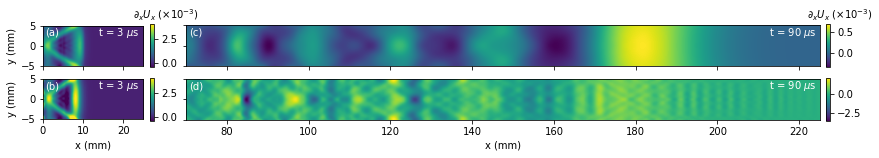

In [17]:
nrows = 2
ncols = 2
wratios = [1, 6]
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2), #tight_layout=True, 
                         sharey=True, sharex='col', 
                         gridspec_kw={'width_ratios': wratios})
xlims = [[0, 25], [70, 225]]
ylims = [-body.Hy/2, body.Hy/2]
y = np.linspace(*ylims, 101)
time_idx = [7, -1]
U_list = [U_ret, U_no_visc]
dx = [-0.5, -3]
letter_coords = [[[0.02, 0.75], [0.55, 0.75]], [[0.005, 0.75], [0.92, 0.75]]]
label_coords = [[0.9, 1.16], [0.98, 1.16]]
vmax = [4, 4, None, None]
vmin = [-0.4, -0.4, None, None]
for i_col, ax in enumerate(axes[0]):
    k = i_col*nrows + 0
    x = np.linspace(*xlims[i_col], int(np.diff(xlims[i_col]))*10 + 1)
    u = -U_ret[time_idx[i_col], 0].diff(0)(x, y, 0)
    im = ax.imshow(u.T, extent=(*xlims[i_col], *ylims), vmax=vmax[k], vmin=vmin[k])
    ax.set_xlim(xlims[i_col])
    ax.text(*letter_coords[i_col][0], '(' + 'abcdef'[k] + ')', transform=ax.transAxes, c='w')
    ax.text(*letter_coords[i_col][1], 't = {} $\mu$s'.format(str(int(T[time_idx[i_col]]))), 
            transform=ax.transAxes, c='w')
    if i_col == 0:
        ax.set_ylabel('y (mm)')
    fig.colorbar(im, ax=ax, pad=0.05/wratios[i_col], aspect=10)
    ax.text(*label_coords[i_col], r'$\partial_x U_x \ (\times 10^{-3})$', transform=ax.transAxes)
for i_col, ax in enumerate(axes[1]):
    k = i_col*nrows + 1
    x = np.linspace(*xlims[i_col], int(np.diff(xlims[i_col]))*10 + 1)
    u = -U_no_visc[time_idx[i_col], 0].diff(0)(x+dx[i_col], y, 0) 
    im = ax.imshow(u.T, extent=(*xlims[i_col], *ylims), vmax=vmax[k], vmin=vmin[k])
    ax.set_xlim(xlims[i_col])
    ax.set_xlabel('x (mm)')
    ax.text(*letter_coords[i_col][0], '(' + 'abcdef'[k] + ')', transform=ax.transAxes, c='w')
    ax.text(*letter_coords[i_col][1], 't = {} $\mu$s'.format(str(int(T[time_idx[i_col]]))), 
            transform=ax.transAxes, c='w')
    if i_col == 0:
        ax.set_ylabel('y (mm)')
    fig.colorbar(im, ax=ax, pad=0.05/wratios[i_col], aspect=10, )
fig.subplots_adjust(left=0.041, right=1.078, top=0.89, bottom=0.22, hspace=0.25, wspace=0.04)

## Some other plots for the simulations on dense meshes

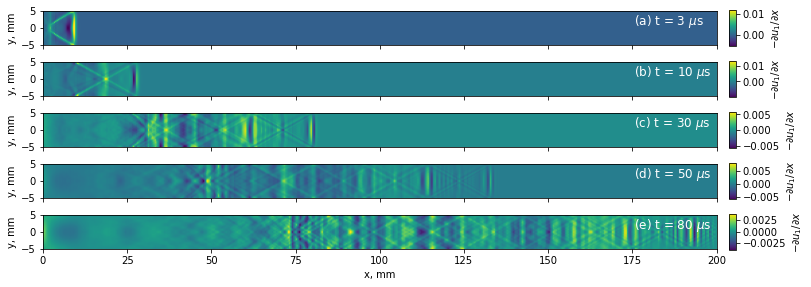

In [9]:
t = [5, 12, 32, 52, -1]
xmax = U.mesh.grid()[0][-1]
x = np.linspace(-0, xmax, num=501)
fig, ax = plot_deformations_many_scales(U, t, x=x)

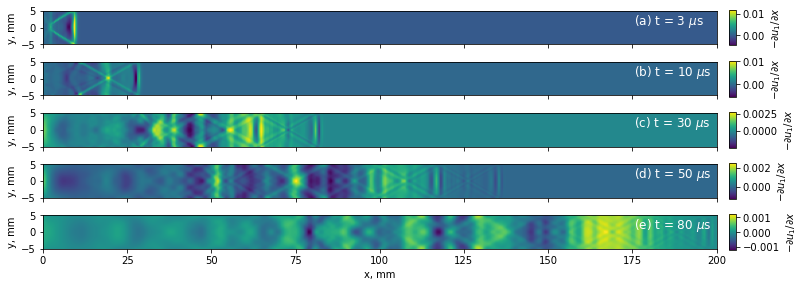

In [6]:
t = [5, 12, 32, 52, -1]
xmax = U.mesh.grid()[0][-1]
x = np.linspace(-0, xmax, num=501)
fig, ax = plot_deformations_many_scales(U, t, x=x)